In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import

keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D
import tensorflow as tf

np.random.seed(0)
cmap = random_label_cmap()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

print(tf.__version__)

GPU is available
2.10.1


In [2]:
import os
from glob import glob
pths = [r'\\169.254.138.20\Andre\data\PDAC Purity Project\PDAC PURITY Final Analysis\LCM_H&Es_10x\czi\ometiff20xv2']
# pths=[r'\\10.99.68.52\Kiemendata\PanIN phenotyping\PDAC Purity Project\LCM H&Es\try 20x AK']
# WSIs = [glob(f'{pth}\*.ome.tiff') for pth in pths]
WSIs = [glob(f'{pth}\*.tif') for pth in pths]


In [11]:
# WSIs[0]

'\\\\169.254.138.20\\Andre\\data\\PDAC Purity Project\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2\\PD_14 1F LCM.tif'

In [12]:
img_pths = [img_pth for p, img_pth in enumerate(WSIs[0])]
slide=4
# img_pths[slide]
img = imread(img_pths[slide])

In [13]:
img = img/255
img.shape

(28486, 56359, 3)

In [14]:
import json
from stardist.models import Config2D, StarDist2D

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model
# model = load_model(r"\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\fallopian_tube_12_7_2023_lr_0.001_epochs_400_pt_40")
model = load_model(r"\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6883699162882626, nms=0.3) 


In [15]:
labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))


effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 128/128 [06:13<00:00,  2.92s/it]


In [22]:
tile_size = 512*1

y_cor = 16000
y_cor_end = y_cor + tile_size
x_cor = 32000
x_cor_end = x_cor + tile_size

cropped_img = img[y_cor:y_cor_end, x_cor:x_cor_end]
cropped_lbl = labels[y_cor:y_cor_end, x_cor:x_cor_end]

lbl_cmap = random_label_cmap()

In [27]:
pths[0]

'\\\\169.254.138.20\\Andre\\data\\PDAC Purity Project\\PDAC PURITY Final Analysis\\LCM_H&Es_10x\\czi\\ometiff20xv2'

In [29]:
import tifffile

outpth = os.path.join(pths[0], '512_tiles_20x')
os.makedirs(outpth, exist_ok=True)
os.makedirs(os.path.join(outpth, 'labels'), exist_ok=True)

tifffile.imwrite(os.path.join(outpth, 'cropped_img.tiff'), cropped_img)
tifffile.imwrite(os.path.join(outpth, 'labels', 'cropped_lbl.tiff'), cropped_lbl)

TypeError: unhashable type: 'list'

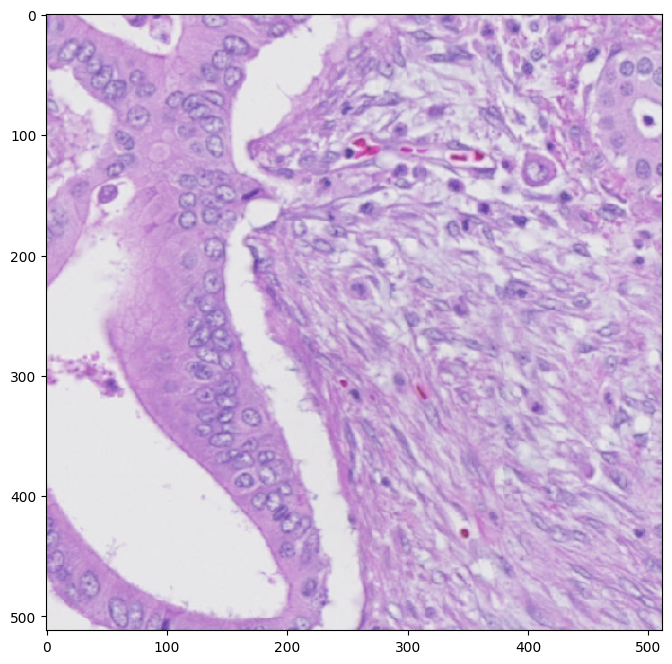

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.25)
plt.axis('off')
plt.show()